1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

По сути дублирует файл из материалов к уроку, нужно просто прогнать для бустинга и логрега

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
        classification_report, precision_recall_curve, confusion_matrix)


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [5]:
df.drop(['RowNumber','CustomerId'], axis=1, inplace=True)

In [6]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], shuffle=True, random_state=0, stratify=df['Exited'])

In [8]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [9]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

**1. Бустинг**

In [12]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [14]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.02036599, 0.11465145, 0.02295217, 0.04761298, 0.22451241,
       0.01325713, 0.14187688, 0.16083293, 0.20438141, 0.03579762])

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.326575, F-Score=0.622, Precision=0.650, Recall=0.595


In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1828  163]
 [ 207  302]]


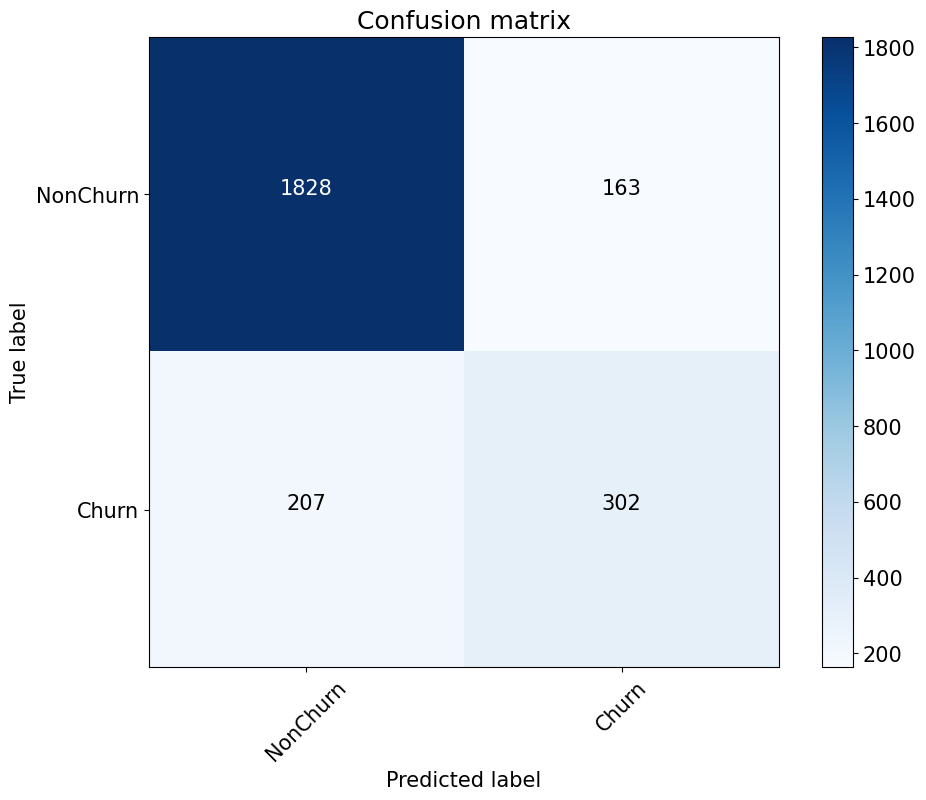

In [17]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

**2. Логистическая регрессия**

In [18]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', LogisticRegression(random_state=42))])

In [21]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


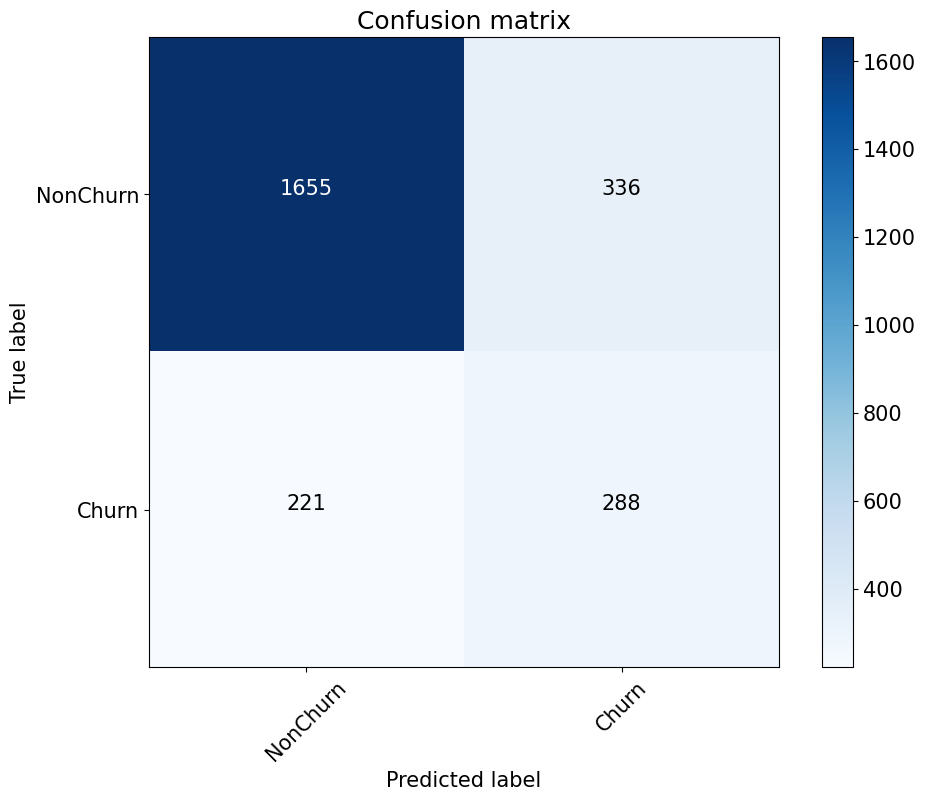

In [23]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Для модели RandomForestClassifier
####*TP*=314   *FP*=159   *FN*=195   *TN*=1832
Если принять во внимание что каждый клиент приносит нам 2 доллара, а расходы на его удержание составляют 1, то эта модель(в гипотетическом случае, что мы удерживаем всех клиентов, которых пытаемся удержать) принесет нам следующий результат: 314Х2=618 долл. -прибыль с удержаных клиентов, 159X1=159 долл. - потери на клиентах которые не собирались уходить, но модель их отнесла в отток($FP$), и 195Х2=390 долл. упущенная прибыль на клиентах которых модель неправильно отметила как лояльных, но которые на самом деле попали в отток($FN$)

Итого: $618-159-390=69$ долл.


Для модели логистической регрессии:
$(323 \cdot 2)-473-(186\cdot2)=646-473-372=-199$ долл